In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import random
import sys
sys.path.insert(0,'..')

from dfibert.tracker.nn.rl import Agent
import dfibert.envs.RLTractEnvironment as RLTe
from dfibert.tracker import save_streamlines

import matplotlib.pyplot as plt
%matplotlib notebook

#from train import load_model

# I. HCP Tracking
The environment is able to run tracking on a fixed set of datasets. At the moment, it is able to load HCP data as well as ISMRM data. The following cells shows the initalisation of our environment on HCP dataset `100307` while seed points are automatically determined at voxels with fa-value >= 0.2 via `seeds = None`.

In [ ]:
env = RLTe.RLTractEnvironment(step_width=0.8, dataset = '100307',
                              device = 'cpu', seeds = None, tracking_in_RAS = False,
                              odf_state = False, odf_mode = "DTI")

In [ ]:
streamlines = env.track()

We can also directly visualize our streamlines in this notebook by `ax.plot3d`. However, a single streamline is typically very hard to comprehend so this is merely one tool to qualitatively reason about major bugs in our tracking code.

In [ ]:
%matplotlib notebook
streamline_index = 9
streamline_np = np.stack(streamlines[streamline_index])

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(streamline_np[:,0], streamline_np[:,1], streamline_np[:,2])
#plt.legend(['gt', 'agent'])
plt.legend('agent')

# II. Evaluation of Cortico Spinal Tract @ ISMRM benchmark data
We will now be using our environment along with our reward function to track streamlines on the ISMRM dataset. For this purpose, we first initialise our environment and set seed points to the cortico spinal tract. We precomputed seed points in IJK for our ISMRM dataset. These seeds will now be loaded into our environment.

In [3]:
seeds_CST = np.load('data/ismrm_seeds_CST.npy')
seeds_CST = torch.from_numpy(seeds_CST)

In [8]:
env = RLTe.RLTractEnvironment(dataset = 'ISMRM', step_width=0.8,
                            device = 'cpu', seeds = seeds_CST[0:,:], action_space=100,
                              tracking_in_RAS = False, odf_state = False, odf_mode = "DTI")

Loading dataset #  ISMRM
Init tract masks for neuroanatomical reward


/home/pia/anaconda3/envs/defi/lib/python3.9/site-packages/dipy/core/sphere.py:187: UserWarning: Vertices are not on the unit sphere.
  warnings.warn("Vertices are not on the unit sphere.")


Tracking itself can now be done by basically calling the `.track()` function that tracks our streamlines from each of the provided seed points in a forward and backward direciton.

In [5]:
streamlines = env.track()

  0%|          | 0/1000 [00:00<?, ?it/s]

Initialising ODF
DTI-based ODF computation


100%|██████████| 1000/1000 [08:14<00:00,  2.02it/s]


The streamlines are now stored as VTK file. The nice thing about this format is that we can directly import the streamlines into 3dSlicer via the slicer-dMRI extension.

In [6]:
streamlines_ras = [env.dataset.to_ras(sl) for sl in streamlines]

In [7]:
# save_streamlines(streamlines=streamlines_ras, path="ismrm_cst2_ras_100actions_hemi.vtk")
save_streamlines(streamlines=streamlines_ras, path="ismrm_test.vtk")

In [ ]:
def convPoint(p, dims):
    dims = dims - 1
    return (p - dims/2.) / (dims/2.)

def interpolate3dAtt(data, positions):
    # Data is supposed to be CxHxWxD
    # normalise coordinates into range [-1,1]
    pts = positions.to(torch.float)
    pts = convPoint(pts, torch.tensor(data.shape[1:4]))
    # reverse pts
    pts = pts[:,(2,1,0)]
    # trilinear interpolation
    return torch.nn.functional.grid_sample(data.unsqueeze(0), 
                               pts.unsqueeze(0).unsqueeze(0).unsqueeze(0),
                               align_corners = False, mode = "nearest")

In [ ]:
interpolate3dAtt(env.tractMasksAllBundles, torch.from_numpy(np.array([[30,50,30]]))).squeeze().shape

In [ ]:
torch.mean(na_reward_history, dim = 0)

In [ ]:
na_reward_history[0,:] = 1

In [ ]:
na_reward_history = torch.zeros((env.maxSteps, env.tractMasksAllBundles.shape[0]))

In [ ]:
from torch.utils.data import Dataset, DataLoader
from dfibert.tracker import save_streamlines, load_streamlines

class FiberBundleDatasetv2(Dataset):
    def __init__(self, path_to_files, b_val = 1000, device = "cpu", dataset = None):
        streamlines = load_streamlines(path=path_to_files)
        
        if(dataset is None):
            preprocessor = DataPreprocessor().normalize().crop(b_val).fa_estimate()
            dataset = preprocessor.get_ismrm(f"data/ISMRM2015/")
        self.dataset = dataset
        self.streamlines = [torch.from_numpy(self.dataset.to_ijk(sl)).to(device) for sl in streamlines]
        self.tractMask = torch.zeros(self.dataset.binary_mask.shape)
        
        for sl in self.streamlines:
            pi = torch.floor(sl).to(torch.long)
            self.tractMask[pi.chunk(chunks=3, dim = 1)] = 1
    
    def __len__(self):
        return len(self.streamlines)
    
    def __getitem__(self, idx):
        streamline = self.streamlines[idx]
        sl_1 = streamline[0:-2]
        sl_2 = streamline[1:-1]
        return sl_1, sl_2


In [ ]:
fibv2.streamlines[0].chunk(chunks=3, dim = 1)[3]

In [ ]:
fibv2 = FiberBundleDatasetv2(path_to_files="data/ISMRM2015/gt_bundles/SLF_left.fib", dataset = dataset)

In [ ]:
fibv1 = FiberBundleDataset(path_to_files="data/ISMRM2015/gt_bundles/SLF_left.fib", dataset = dataset)

In [ ]:
torch.sum(fibv2.tractMask)

In [ ]:
torch.sum(fibv1.tractMask)

# Reinforcement Learning
## DQN

In [3]:
%matplotlib inline
from dfibert.envs.NARLTractEnvironment import NARLTractEnvironment as RLEnv

In [4]:
# init env
#seeds_CST = np.load('data/ismrm_seeds_CST.npy')
#seeds_CST = torch.from_numpy(seeds_CST)
env = RLEnv(dataset = 'ISMRM', step_width=0.2,
            device = 'cpu', action_space=20,
            odf_mode = "CSD")#, seeds = seeds_CST)

Loading dataset #  ISMRM
Initialising ODF
CSD-based ODF computation


/home/pia/anaconda3/envs/defi/lib/python3.9/site-packages/dipy/reconst/csdeconv.py:240: UserWarning: Number of parameters required for the fit are more than the actual data points
  warnings.warn(msg, UserWarning)
/home/pia/anaconda3/envs/defi/lib/python3.9/site-packages/dipy/core/sphere.py:187: UserWarning: Vertices are not on the unit sphere.
  warnings.warn("Vertices are not on the unit sphere.")


In [5]:
from dipy.tracking.utils import random_seeds_from_mask
temp_seeds = env.seeds
env.seeds = random_seeds_from_mask(env.dataset.binary_mask,
seeds_count=10000,
seed_count_per_voxel=False,
affine=env.dataset.aff)

In [6]:
from dfibert.tracker.nn.rainbow_agent import DQNAgent

In [7]:
# Hyperparameters:
replay_memory_size = 100000
batch_size = 32
target_update = 10000
gamma = 0.95
max_steps = 60000000

path = './training_lower_stepwidth'

In [8]:
agent = DQNAgent(env=env, memory_size = replay_memory_size,
        batch_size = batch_size,
        target_update = target_update,
        gamma = gamma)

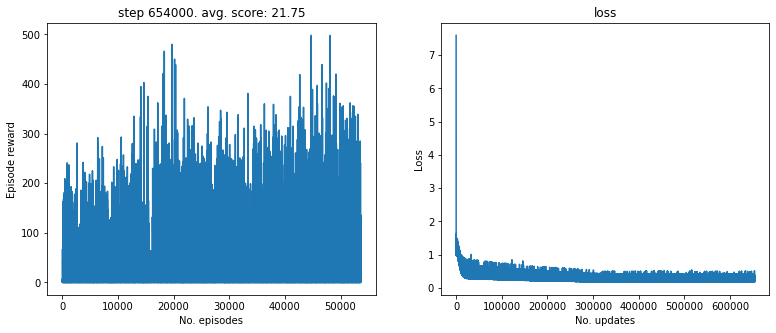

Step number:  654000 Avg. reward:  21.75
Writing checkpoint to ./training_lower_stepwidth/checkpoints/rainbow_654000_21.75.pth


In [9]:
# start training

agent.train(num_steps = max_steps, checkpoint_interval=2000, path = path, plot=True)

In [10]:
# resume the training process
agent.resume_training(path='./training_lower_stepwidth/checkpoints/rainbow_654000_21.75.pth', plot=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# load a saved checkpoint
agent = DQNAgent(env=env, 
        memory_size = replay_memory_size,   # memory + batch size and target update will be overwritten with the
        batch_size = batch_size,            # saved parameters
        target_update = target_update)
num_steps, rewards, losses, max_steps = agent._load_model('./training_lower_stepwidth/checkpoints/rainbow_654000_21.75.pth')

Loading checkpoint file ./training_lower_stepwidth/checkpoints/rainbow_654000_21.75.pth


In [9]:
# calculate and save tractogram with trained agent
_ = agent.create_tractogram(path="ismrm_defi_21.75.vtk")

100%|██████████| 10000/10000 [09:47<00:00, 17.01it/s]


In [12]:
streamlines = env.track()

100%|██████████| 10000/10000 [06:58<00:00, 23.88it/s]


In [13]:
streamlines = list(filter(None, streamlines))
save_streamlines(streamlines=streamlines, path="test_tract_csd.vtk")

In [ ]:
counter = 0
for i in range(len(streamlines)):
    if len(streamlines[i])>10:
        counter +=1

print(counter)

In [ ]:
# plot rewards and losses for loaded checkpoint
%matplotlib inline
agent._plot(num_steps, rewards, losses)